In [147]:
import networkx as nx
import altair as alt
import numpy as np
import pandas as pd

from numpy.random import randint
from scipy.io import loadmat
from ucimlrepo import fetch_ucirepo 
from collections import Counter
from itertools import product

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# HW1

## Q1

Consider the wheel graph on 7 vertices below. Assume each triangle is equilateral, or use [the graph distance](https://mathworld.wolfram.com/GraphDistance.html).

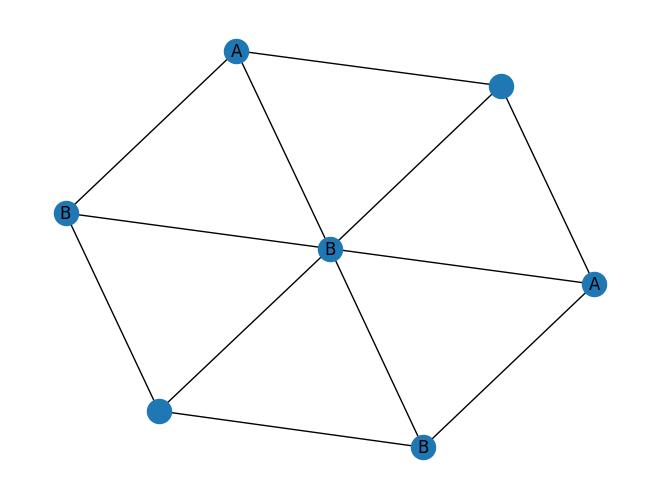

In [2]:
G = nx.wheel_graph(7)
pos = nx.spring_layout(G)
nx.draw(G,pos)
labels = {x: y for x,y in enumerate(['B','A','B','','B','A',''])}
res = nx.draw_networkx_labels(G,pos,labels)

1. Apply the k-NN algorithm by hand with $k=1$ to fill-in the missing labels. You must explain why you gave the specific label.
   
2. This time apply the k-NN by hand again with $k=3$ to fill-in the missing labels. Again, you must explain why you gave the specific label.

3. Apply k-means algorithm by hand with k=2. Use the unlabeled points as the initial centroids.

4. What happens with the central vertex? What are the centroids after the first run? Notice that if we randomly assign the central vertex, it affects the subsequent iterations.

5. Verify that iterations stabilize after first run.

6. What happens if we change the initial centroids? Explain.

## Q2

Consider the dataset:

In [14]:
image = loadmat('../data/PaviaU.mat')['paviaU']
gt = loadmat('../data/PaviaU_gt.mat')['paviaU_gt']

The dataset is a hyperspectral image collected by the ROSIS sensor over Pavia, nothern Italy. The image is 610 x 340 pixels, and the number of spectral bands is 103, but some of the samples in the images contain no information and have to be discarded before the analysis. Image groundtruth differentiates 9 classes.

* asphalt (1)
* meadows (2)
* gravel (3)
* trees (4)
* painted metal (5)
* soil (6)
* bitumen (7)
* bricks (8)
* shadows (9)

In [15]:
image.shape
gt.shape

(610, 340, 103)

(610, 340)

Notice that each pixel $(i,j)$ contains a 103-dimensional vector $p_{i,j}$.

In [16]:
i = randint(610)
j = randint(340)
image[i,j]

array([1057,  725,  568,  531,  462,  379,  335,  315,  275,  251,  255,
        210,  185,  193,  186,  157,  141,  148,  157,  154,  187,  247,
        267,  290,  333,  363,  387,  394,  414,  454,  472,  475,  452,
        445,  445,  429,  400,  381,  387,  383,  375,  365,  359,  358,
        348,  338,  341,  339,  334,  336,  337,  318,  310,  303,  290,
        271,  251,  242,  236,  220,  202,  198,  205,  227,  281,  370,
        473,  621,  803, 1029, 1250, 1436, 1632, 1854, 2102, 2376, 2592,
       2779, 2922, 3041, 3145, 3174, 3112, 3139, 3278, 3304, 3307, 3266,
       3212, 3157, 3146, 3160, 3190, 3225, 3205, 3104, 3059, 3083, 3072,
       3053, 3010, 3036, 3144], dtype=uint16)

We are going to write k-NN models to associate a class label 1 to 9 as above to the pixel in the image, and measure the accuracy of the model.

1. Split the dataset into train and test. Use 90% of the data for training, and the remaining 10% for test. We are going to use *accuracy* which is calculated the ration of the number of correctly labelled points by the total number of pixels.

2. Construct k-NN models for $k=1,3,5,7, 9$. For two pixels $(i,j)$ and $(i',j')$ use the distance
$ d((i,j),(i',j')) = max(|i-i'|,|j-j'|) $. Decide which $k$ yields the best result.

3. Construct k-NN models for $k=1,3,5,7, 9$. For two pixels $(i,j)$ and $(i',j')$ use the distance $d((i,j),(i',j')) = \| p_{i,j} - p_{i',j'} \|$ where $\|\cdot\|$ denotes the Euclidean norm of a vector. Decide which $k$ yields the best results.

In [172]:
indices = np.array(np.where(gt!=0)).T
vectors = image[gt!=0]
labels = gt[gt!=0]

In [173]:
def experiment(X,y,k,metric,train=0.9):
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=train)
    classifier = KNN(n_neighbors=k,metric=metric)
    classifier.fit(X_train,y_train)
    return classifier.score(X_test,y_test)

In [174]:
[{'k': k, 'score': experiment(indices,labels,k,'infinity',train=0.9)} for k in [1,3,5,7,9]]

[{'k': 1, 'score': 1.0},
 {'k': 3, 'score': 1.0},
 {'k': 5, 'score': 0.9992987377279102},
 {'k': 7, 'score': 0.9983637213651239},
 {'k': 9, 'score': 0.998831229546517}]

In [175]:
[{'k': k, 'score': experiment(vectors,labels,k,'euclidean',train=0.9)} for k in [1,3,5,7,9]]

[{'k': 1, 'score': 0.9050958391771856},
 {'k': 3, 'score': 0.9053295932678822},
 {'k': 5, 'score': 0.9086021505376344},
 {'k': 7, 'score': 0.9079008882655446},
 {'k': 9, 'score': 0.9083683964469378}]

## Q3

Consider [Individual household electric power consumption](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) dataset from the UCI data repository:

In [176]:
electric = fetch_ucirepo(id=235) 

/home/kaygun/.local/lib/python3.11/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [189]:
X = electric['data']['features'].iloc[:,2:]
X

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2075254,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,0.934,0.0,239.7,3.8,0.0,0.0,0.0


1. Clean the data. You may replace the missing values with 0.
2. Apply k-means algorithm to the data with $k=2,3,4,5$.
3. Project the data to the 2-dimensional plane using Linear Discriminant Analysis as I did in the class, with the labels you obtained in step 2 above.
4. Inspect the data with the labels you constructed in step 2. Do these clusters have a visible meaning? Analyze.

In [190]:
X.fillna(0,inplace=True)
X.replace({'?': 0}, inplace=True)
X

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2075254,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [191]:
X.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [195]:
model = KMeans(n_clusters=3)
labels = model.fit_predict(X)

/home/kaygun/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [196]:
projector = LDA(n_components=2)
coords = projector.fit_transform(X,labels)

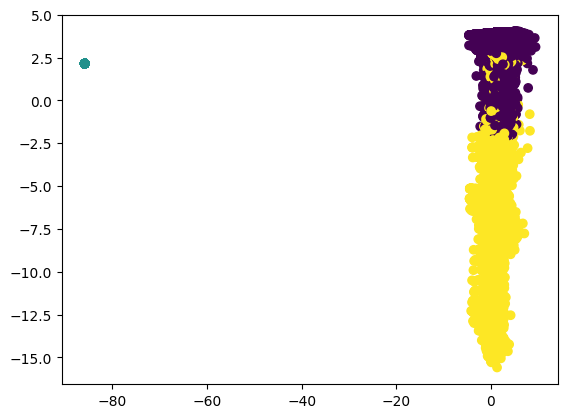

In [197]:
plt.scatter(coords[:,0],coords[:,1],c=labels)

In [198]:
data = X
data['x'] = coords[:,0] 
data['y'] = coords[:,1]
data['label'] = labels
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,x,y,label
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,0.724064,-6.736695,2
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,0.379029,-6.360555,2
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,0.030958,-6.954633,2
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,0.090034,-6.938583,2
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,0.115540,-6.612337,2
...,...,...,...,...,...,...,...,...,...,...
2075254,0.946,0.0,240.43,4.0,0.0,0.0,0.0,1.249409,3.784772,0
2075255,0.944,0.0,240.0,4.0,0.0,0.0,0.0,1.109708,3.781921,0
2075256,0.938,0.0,239.82,3.8,0.0,0.0,0.0,0.707608,3.781255,0
2075257,0.934,0.0,239.7,3.8,0.0,0.0,0.0,0.694898,3.781104,0


In [199]:
alt.Chart(data.sample(5000)).mark_circle(size=100,opacity=0.2).encode(
    x='y',
    y='x',
    color=alt.Color('label').scale(scheme="set1"),
    tooltip=['Global_active_power', 'Global_reactive_power', 'Voltage',
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
).properties(
    width=800,
    height=400
).interactive()

alt.Chart(...)